In [106]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from scipy.special import expit
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [107]:
stock = "ORCL"

df = pd.read_csv(
    f"csv/{stock}_indicators.csv",
    index_col=0,       # use first column ("Date") as index
    parse_dates=[0],    # parse it as datetime
    date_format="ISO8601" #Specify date fromat
) 

X = df.copy()
df["Target"] = (df['Close'].shift(-1) > df['Close']).astype(int)
y = df["Target"]
print("Number of 1s in y:", (y == 1).sum())
print("Number of 0s in y:", (y == 0).sum())

Number of 1s in y: 261
Number of 0s in y: 208


In [108]:
#Scaling
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # manteniamo l'ordine temporale
)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

              precision    recall  f1-score   support

           1       0.54      1.00      0.70        51
           0       0.00      0.00      0.00        43

   micro avg       0.54      0.54      0.54        94
   macro avg       0.27      0.50      0.35        94
weighted avg       0.29      0.54      0.38        94



/home/alessio/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessio/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alessio/MarGui-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

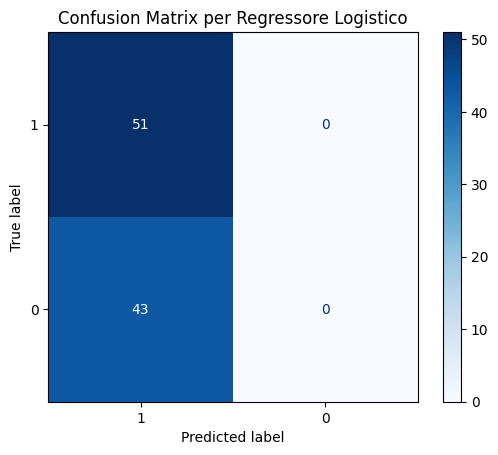

In [109]:
#lr = LogisticRegression(max_iter=2000, solver="liblinear",penalty="l1",random_state=42)
#lr = LogisticRegression(solver="liblinear", verbose=2, max_iter=2000, penalty="l1", C=0.01, random_state=42) # Solo down
#lr = LogisticRegression(solver="liblinear", max_iter=2000, penalty="l1", C=3, random_state=42)
#lr = LogisticRegression(solver="liblinear", max_iter=2000, penalty="l2", C=0.1, random_state=42)
lr = LogisticRegression(
    solver="saga",
    penalty="l1",
    C=0.07,
    random_state=42,
    max_iter=50,
    verbose=0
)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

print(classification_report(y_test, y_pred, labels=["1","0"]))

cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
disp.plot(cmap = "Blues")
plt.title("Confusion Matrix per Regressore Logistico")
plt.show()

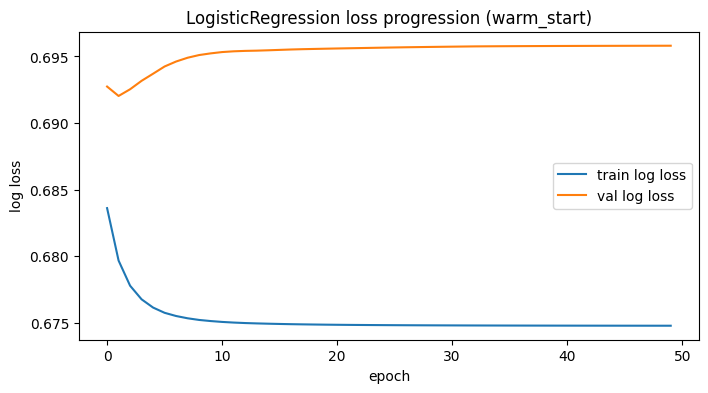

              precision    recall  f1-score   support

           1       0.60      0.51      0.55        51
           0       0.51      0.60      0.55        43

    accuracy                           0.55        94
   macro avg       0.56      0.56      0.55        94
weighted avg       0.56      0.55      0.55        94



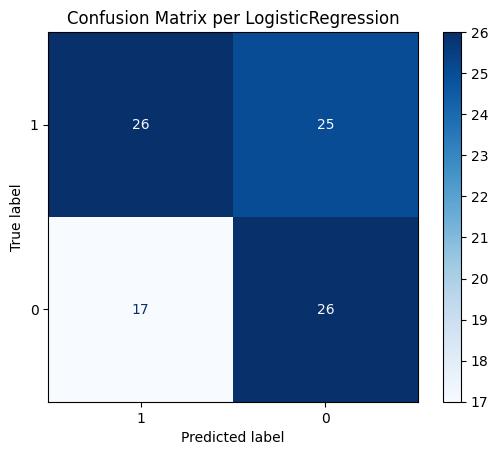

In [110]:
from sklearn.exceptions import ConvergenceWarning
import warnings

lr = LogisticRegression(
    solver="saga",
    penalty="l1",
    C=0.07,
    random_state=42,
    warm_start=True,
    max_iter=1,
    verbose=0
)

n_epochs = 50
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # suppress the per-fit convergence warning since we intentionally use max_iter=1
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lr.fit(X_train_scaled, y_train)

    # compute probabilities and log-loss for train and val
    train_proba = lr.predict_proba(X_train_scaled)
    val_proba = lr.predict_proba(X_test_scaled)
    train_losses.append(log_loss(y_train, train_proba))
    val_losses.append(log_loss(y_test, val_proba))

# plot loss progression
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="train log loss")
plt.plot(val_losses, label="val log loss")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.legend()
plt.title("LogisticRegression loss progression (warm_start)")
plt.show()

# final evaluation
y_pred = lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred, labels=[1, 0]))

cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix per LogisticRegression")
plt.show()

In [111]:
# 0.56, no erly stop
params = {
    'objective': 'binary:logistic',   # binary classification with logistic loss
    'eval_metric': 'logloss',         # loss function to track
    'booster': 'gbtree',
    'alpha': 1.0,                     # L1 regularization term
    'lambda': 0.0,                    # set L2 regularization to zero if pure L1 is desired
    'eta': 0.03,                      # learning rate
    'max_depth': 3,                  # depth of trees
    'subsample': 0.9,                # row sampling (helps reduce overfitting)
    'colsample_bytree': 0.9,        # feature sampling
    'scale_pos_weight': 0.8,         # Balanced the inputs
    'random_state': 42,
}

#0.57
params = {
    'objective': 'binary:logistic',   # binary classification with logistic loss
    'eval_metric': 'logloss',         # loss function to track
    'booster': 'gbtree',
    'alpha': 0.58,                     # L1 regularization term
    'lambda': 0.0,                    # set L2 regularization to zero if pure L1 is desired
    'eta': 0.026,                      # learning rate
    'max_depth': 3,                  # depth of trees
    'subsample': 0.6,                # row sampling (helps reduce overfitting)
    'colsample_bytree': 0.84,        # feature sampling
    'scale_pos_weight': 0.8,         # Balanced the inputs
    'random_state': 42,
}
#temp
params = {
    'objective': 'binary:logistic',   # binary classification with logistic loss
    'eval_metric': 'logloss',         # loss function to track
    'booster': 'gbtree',
    'alpha': 0.8,                     # L1 regularization term
    'lambda': 0.0,                    # set L2 regularization to zero if pure L1 is desired, (useless)
    'eta': 0.026,                      # learning rate
    'max_depth': 5,                  # depth of trees
    'subsample': 0.8,                # row sampling (helps reduce overfitting)
    'colsample_bytree': 0.82,        # feature sampling
    'scale_pos_weight': 1.1,         # Balanced the inputs
    'random_state': 42,
}

# 0.59 but bias towrds 1
params = {
    'objective': 'binary:logistic',   # binary classification with logistic loss
    'eval_metric': 'logloss',         # loss function to track
    'booster': 'gbtree',
    'alpha': 0.58,                     # L1 regularization term
    'lambda': 0.0,                    # set L2 regularization to zero if pure L1 is desired
    'eta': 0.026,                      # learning rate
    'max_depth': 6,                  # depth of trees
    'subsample': 0.7,                # row sampling (helps reduce overfitting)
    'colsample_bytree': 0.8,        # feature sampling
    'scale_pos_weight': 1.244,         # Balanced the inputs
    'random_state': 42,
}

# 0.6 35 early, bias towrds 0
params = {
    'objective': 'binary:logistic',   # binary classification with logistic loss
    'eval_metric': 'logloss',         # loss function to track
    'booster': 'gbtree',
    'alpha': 0.7,                     # L1 regularization term
    'lambda': 0.0,                    # set L2 regularization to zero if pure L1 is desired
    'eta': 0.02,                      # learning rate
    'max_depth': 5,                  # depth of trees
    'subsample': 0.5,                # row sampling (helps reduce overfitting)
    'colsample_bytree': 0.8,        # feature sampling
    'scale_pos_weight': 0.85,         # Balanced the inputs
    'random_state': 42,
}

params = {
    'objective': 'binary:logistic',   # binary classification with logistic loss
    'eval_metric': 'logloss',         # loss function to track
    'booster': 'gbtree',
    'alpha': 0.7,                     # L1 regularization term
    'lambda': 0.0,                    # set L2 regularization to zero if pure L1 is desired
    'eta': 0.025,                      # learning rate
    'max_depth': 4,                  # depth of trees
    'subsample': 0.8,                # row sampling (helps reduce overfitting)
    'colsample_bytree': 0.8,        # feature sampling
    'scale_pos_weight': 1.1,         # Balanced the inputs
    'random_state': 42,
}

ratio:  1.2548076923076923


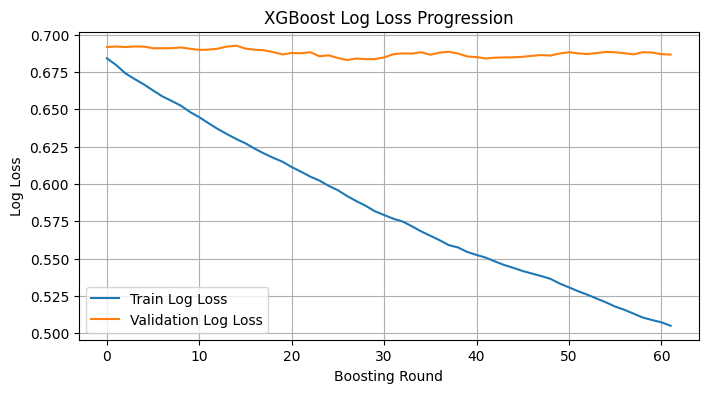


Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.57      0.60        51
           0       0.55      0.63      0.59        43

    accuracy                           0.60        94
   macro avg       0.60      0.60      0.60        94
weighted avg       0.60      0.60      0.60        94

Accuracy: 0.5957446808510638
Final Validation Log Loss: 0.6867094036380813


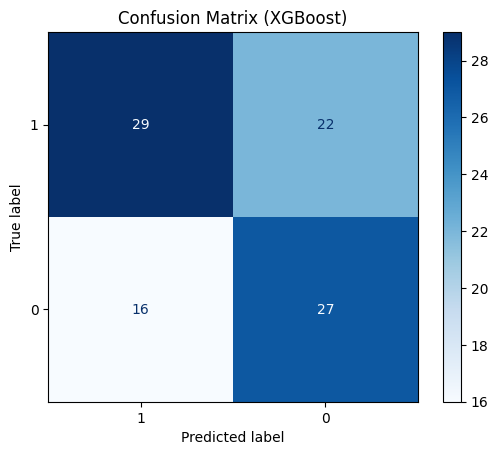

In [ ]:
ratio = (y == 1).sum()/(y == 0).sum()
print("ratio: ", ratio)

params = {
    'objective': 'binary:logistic',   # binary classification with logistic loss
    'eval_metric': 'logloss',         # loss function to track
    'booster': 'gbtree',
    'alpha': 0.7,                     # L1 regularization term
    'lambda': 0.0,                    # set L2 regularization to zero if pure L1 is desired
    'eta': 0.02,                      # learning rate
    'max_depth': 5,                  # depth of trees
    'subsample': 0.5,                # row sampling (helps reduce overfitting)
    'colsample_bytree': 0.8,        # feature sampling
    'scale_pos_weight': 0.85,         # Balanced the inputs
    'random_state': 42,
}

num_rounds = 500 # number of max boosting iterations

# Convert to DMatrix (optimized data structure for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

# ================================
# 3. Train with Evaluation for Each Iteration
# ================================
evals = [(dtrain, 'train'), (dval, 'validation')]
evals_result = {}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_rounds,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False,
    early_stopping_rounds = 35
)

# ================================
# 4. Plot the Loss Curve
# ================================
train_logloss = evals_result['train']['logloss']
val_logloss = evals_result['validation']['logloss']

plt.figure(figsize=(8, 4))
plt.plot(train_logloss, label='Train Log Loss')
plt.plot(val_logloss, label='Validation Log Loss')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss Progression')
plt.legend()
plt.grid()
plt.show()

# ================================
# 5. Final Evaluation
# ================================
# Predict class labels
y_pred_proba = model.predict(dval)
y_pred = (y_pred_proba >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=[1, 0]))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Final Validation Log Loss:", log_loss(y_test, y_pred_proba))

cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (XGBoost)")
plt.show()

In [113]:
import os
import joblib

os.makedirs("models", exist_ok=True)

artifact = {
    "model": model,
    "scaler": None,
    "features": X_train.columns.tolist() if hasattr(X_train, "columns") else None,
}

out_path = f"models/{stock}.joblib"
joblib.dump(artifact, out_path)

['models/ORCL.joblib']